<a href="https://colab.research.google.com/github/apchavezr/-Analisis_Grandes_Volumenes_Datos/blob/main/PySpark_ETL_Limpieza_Transformacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica: Transformación y limpieza de datos con PySpark

Este notebook guía al estudiante en la aplicación de funciones comunes de limpieza y transformación en PySpark, utilizando datos simulados. Se utilizarán técnicas como eliminación de duplicados, imputación de valores faltantes, conversión de tipos y normalización textual. Al final, se visualizan los resultados con `matplotlib`.


In [1]:
# Configuración del entorno de PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import StructType, StringType, IntegerType, TimestampType
from datetime import datetime

spark = SparkSession.builder \
    .appName("Limpieza_Datos_PySpark") \
    .getOrCreate()

## Simulación de datos de sensores urbanos (con errores comunes)

In [2]:
# Esquema de los datos simulados
schema = StructType() \
    .add("sensor_id", StringType()) \
    .add("zona", StringType()) \
    .add("valor", StringType()) \
    .add("timestamp", TimestampType())

data = [
    ("s-001", "USQN", "35", datetime.now()),
    ("s-002", "CHPN", "48", datetime.now()),
    ("s-002", "CHPN", "48", datetime.now()),  # duplicado
    ("s-003", "TEUS", None, datetime.now()),    # valor faltante
    ("s-004", "USQN", "n/a", datetime.now()),  # error de formato
]

df = spark.createDataFrame(data, schema=schema)
df.show(truncate=False)

+---------+----+-----+--------------------------+
|sensor_id|zona|valor|timestamp                 |
+---------+----+-----+--------------------------+
|s-001    |USQN|35   |2025-04-21 18:21:16.053048|
|s-002    |CHPN|48   |2025-04-21 18:21:16.053051|
|s-002    |CHPN|48   |2025-04-21 18:21:16.053051|
|s-003    |TEUS|NULL |2025-04-21 18:21:16.053052|
|s-004    |USQN|n/a  |2025-04-21 18:21:16.053052|
+---------+----+-----+--------------------------+



## Aplicación de transformaciones y limpieza de datos

In [3]:
# 1. Eliminar duplicados
df_clean = df.dropDuplicates()

# 2. Reemplazar texto no válido por null
df_clean = df_clean.withColumn("valor", regexp_replace("valor", "[^0-9]", ""))

# 3. Imputación de valores faltantes con 0
df_clean = df_clean.fillna({"valor": "0"})

# 4. Conversión de tipo
df_clean = df_clean.withColumn("valor", col("valor").cast("int"))

# 5. Normalización de zonas
df_clean = df_clean.withColumn("zona", when(col("zona") == "USQN", "Usaquén")
                                         .when(col("zona") == "CHPN", "Chapinero")
                                         .when(col("zona") == "TEUS", "Teusaquillo")
                                         .otherwise("Otra"))

df_clean.show(truncate=False)

+---------+-----------+-----+--------------------------+
|sensor_id|zona       |valor|timestamp                 |
+---------+-----------+-----+--------------------------+
|s-002    |Chapinero  |48   |2025-04-21 18:21:16.053051|
|s-001    |Usaquén    |35   |2025-04-21 18:21:16.053048|
|s-004    |Usaquén    |NULL |2025-04-21 18:21:16.053052|
|s-003    |Teusaquillo|0    |2025-04-21 18:21:16.053052|
+---------+-----------+-----+--------------------------+



## Visualización de los valores por zona

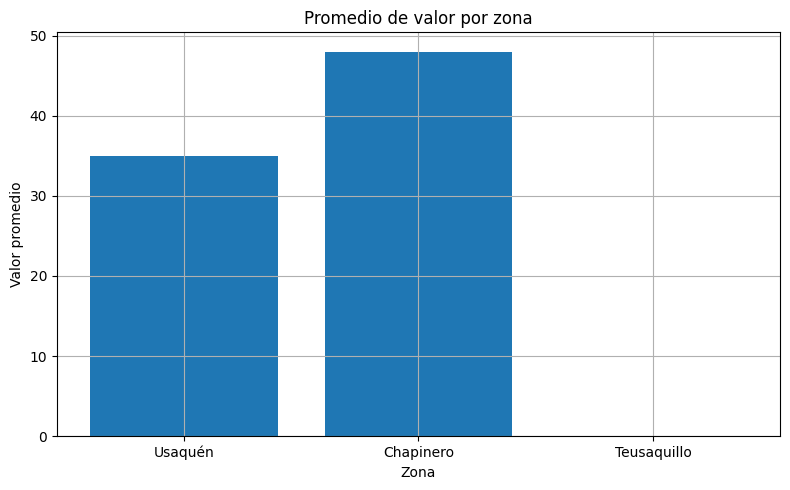

In [4]:
# Conversión a Pandas para graficar
import matplotlib.pyplot as plt

pdf = df_clean.groupBy("zona").avg("valor").toPandas()
pdf.columns = ["zona", "valor_promedio"]

plt.figure(figsize=(8, 5))
plt.bar(pdf["zona"], pdf["valor_promedio"])
plt.title("Promedio de valor por zona")
plt.xlabel("Zona")
plt.ylabel("Valor promedio")
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusión
Este ejercicio práctico permite observar cómo PySpark puede utilizarse para llevar a cabo transformaciones y limpieza de datos de forma eficiente. La visualización permite verificar que los valores han sido tratados correctamente y segmentados por zonas normalizadas.

## Explicaciones de las salidas

1. **Visualización inicial del DataFrame (`df.show()`):**
   Se presentan los datos simulados con errores comunes, como duplicados, valores faltantes y datos no válidos como 'n/a'. Esta salida permite identificar los problemas que se deben abordar en la limpieza.

2. **Transformación paso a paso (`df_clean.show()`):**
   Después de aplicar `dropDuplicates()`, se eliminan filas repetidas. Posteriormente:
   - Se reemplazan caracteres no numéricos en la columna `valor`.
   - Se imputan los valores faltantes con '0'.
   - Se convierte `valor` de tipo string a entero con `cast()`.
   - Se normaliza la columna `zona`, asignando nombres legibles como 'Usaquén' o 'Chapinero'.

   Esta salida debe mostrar un DataFrame limpio, sin duplicados ni valores inválidos, listo para análisis o almacenamiento.

3. **Gráfico de barras (`matplotlib`):**
   Se muestra una visualización que resume el valor promedio por zona normalizada. Esta gráfica permite validar visualmente la transformación aplicada y es útil en reportes o paneles de monitoreo.

   Si los valores han sido correctamente transformados, el gráfico mostrará barras proporcionales por zona y sin errores de tipo o texto.